# 1. Import Python packages

To run the following cell, you should have installed all relevant Python packages. \
More information on how to install such packages is provided in the instructions of the 3rd part of the tutorial. 

In [1]:
import pandas as pd
import os
from nltk.metrics import agreement, jaccard_distance
from numpy.linalg import norm

In [2]:
# In case you want to install packages directly without virtual env, you can run this code. Note that you still have to change "<package>"" to the name of the required package
# ! pip install --user <package>

# 2. Prepare variables

Before we can evaluate inter-annotator agreement (IAA), we will first extract and define some relevant variables. \
In our setup, we are interested in information such as:
- Taxonomy of interpersonal emotion regulation strategies
- Annotator names or IDs
- Number of annotators

## 2.1 Taxonomy of interpersonal emotion regulation strategies

We save the interpersonal emotion regulation strategies of our annotation scheme in a constant. \
The constant contains a list of all the strategies we defined.

In [16]:
EMOTION_REG_STRAT = ['Empathy', 'Encouragement', 'Humor', 'Mirroring', 
                     'Perspective', 'Reflection', 'Sharing', 'Solution', 
                     'Validation', 'Reappraisal']

## 2.2 Annotators

We extract the different annotators from the filenames.

The following code snippet requires that the annotated files are in the same folder as this notebook. \
All annotated files should start with the string **labels_** followed by the name/ID of the annotator (e.g., labels_annotator1.xlsx).

In [27]:
# get the path to the folder you're working in
directory_path = os.getcwd()

# Working in a different folder? Run this code & change 'my_path'
# directory_path = os.chdir('my_path')

In [28]:
# extract all filenames that start with 'labels_'
all_files = os.listdir(directory_path)
annotation_files = [file for file in all_files if file.startswith('labels_')]

In [36]:
# method to extract annotator name per file
def extract_annotator(filename):
    filename_no_ext = os.path.splitext(file)[0]
    parts = filename_no_ext.split('_')
    if len(parts) >= 2:
        return '_'.join(parts[1:])
    else:
        print("Do the annotated files start with 'labels_'? Did you put the annotator ID/name in the file name (e.g., labels_annotator1.xlsx)?")

In [38]:
# extract list of annotator names
annotators = []

for file in annotation_files:
    annotator = extract_annotator(file)
    annotators.append(annotator)
    
print(f'The annotators who participated are: {annotators}')

## 2.3 Number of unique annotators

In [8]:
print(f'The unique number of annotators for this task is: {len(set(annotators))}')

# 3. Extract annotations

Once we have prepared the variables, we continue by extracting the annotations from their files.

To this end, we loop through the files starting with 'labels_'. Depending on the file extension, we run a different line of code. Two types of extension are supported in this code, namely .xlsx and .csv.

We then extract the 3rd column from each file, since we expect that this column contains our assigned labels.

The result is saved in a dictionary with the annotator names as key and the annotations as values. As a sanity check, we print this dictionary at the end.

In [12]:
# loop through annotated files & extract assigned labels in df
# save df in dictionary 'annotations_dict': key = annotator; value = assigned labels
annotations_dict = dict()


for file in annotation_files:
    try:
        file_extension = os.path.splitext(file)[1]
        
        if file_extension == '.xlsx':
            df = pd.read_excel(file)
            # labels saved in 3rd column
            labels = df.iloc[:, 2]
            annotations_dict[extract_annotator(file)[0]] = labels
            
        elif file_extension == '.csv':
            df = pd.read_csv(file)
            # labels saved in 3rd column
            labels = df.iloc[:, 2]
            annotations_dict[extract_annotator(file)[0]] = labels
            
    except Exception as e:
            print(f"Error reading {file}: {e}. File saved with .xlsx or .csv extension?")
            
print(annotations_dict)

In [14]:
# method to check for missing labels or typos: returns tuples of annotators & row numbers
def check_annotations(annotations_dict, correct_labels):
    issues = []
    
    for annotator, annotations in annotations_dict.items():
        for i, annotation in annotations.items():
            if pd.isnull(annotation) or annotation not in correct_labels:
                issues.append((annotator, i+2))
            
    return issues

In [17]:
# check for missing annotations/typos
issues = check_annotations(annotations_dict, EMOTION_REG_STRAT)

if not issues:
    print('All annotations are correct. No missing values.')
else:
    print(f'There are some issues with the collected annotations. Please correct these instances before continuing to the next part: \n{issues}')

# 4. Calculating inter-annotator agreement

To measure agreement between annotators, we will use _agreement.AnnotationTask()_ from the nltk.metrics package.
Multiple metrics are supported by the package. For this tutorial, we focus on metrics for categorical annotation tasks.

## 4.1 Put data in right format

_AnnotationTask()_ expects a list of tuples as input. \
Each tuple has to contain these three items and this in the same order as they are listed:
- annotator ID (string), 
- data instance ID (string), 
- annotation

We now loop through the _annotations_dict_ and save our data in the right format.

In [18]:
data = []

for annotator, annotations in annotations_dict.items():
    for item, annotation in enumerate(annotations):
        data.append((annotator, str(item), annotation))
        
print(data)

In the next line, we initialize _AnnotationTask_ with our _data_.

In [20]:
# initialize AnnotationTask()
task = agreement.AnnotationTask(data)

## 4.2 Metrics to measure inter-annotator agreement (IAA)

There are multiple criteria that might influence the metric one chooses to measure agreement between annotators. In case of categorical annotation tasks, the following criteria will play a role in deciding which metric to use:
- Are there two or more annotators?
- Do you have missing annotations?
- Are the labels nominal or ordinal?
- Multiclass or multilabel?

In the diagram, we give a schematical overview of which metrics can be used given the previous questions. We focus on three metrics:
- Cohen's Kappa
- Fleiss' Kappa
- Krippendorff's Alpha

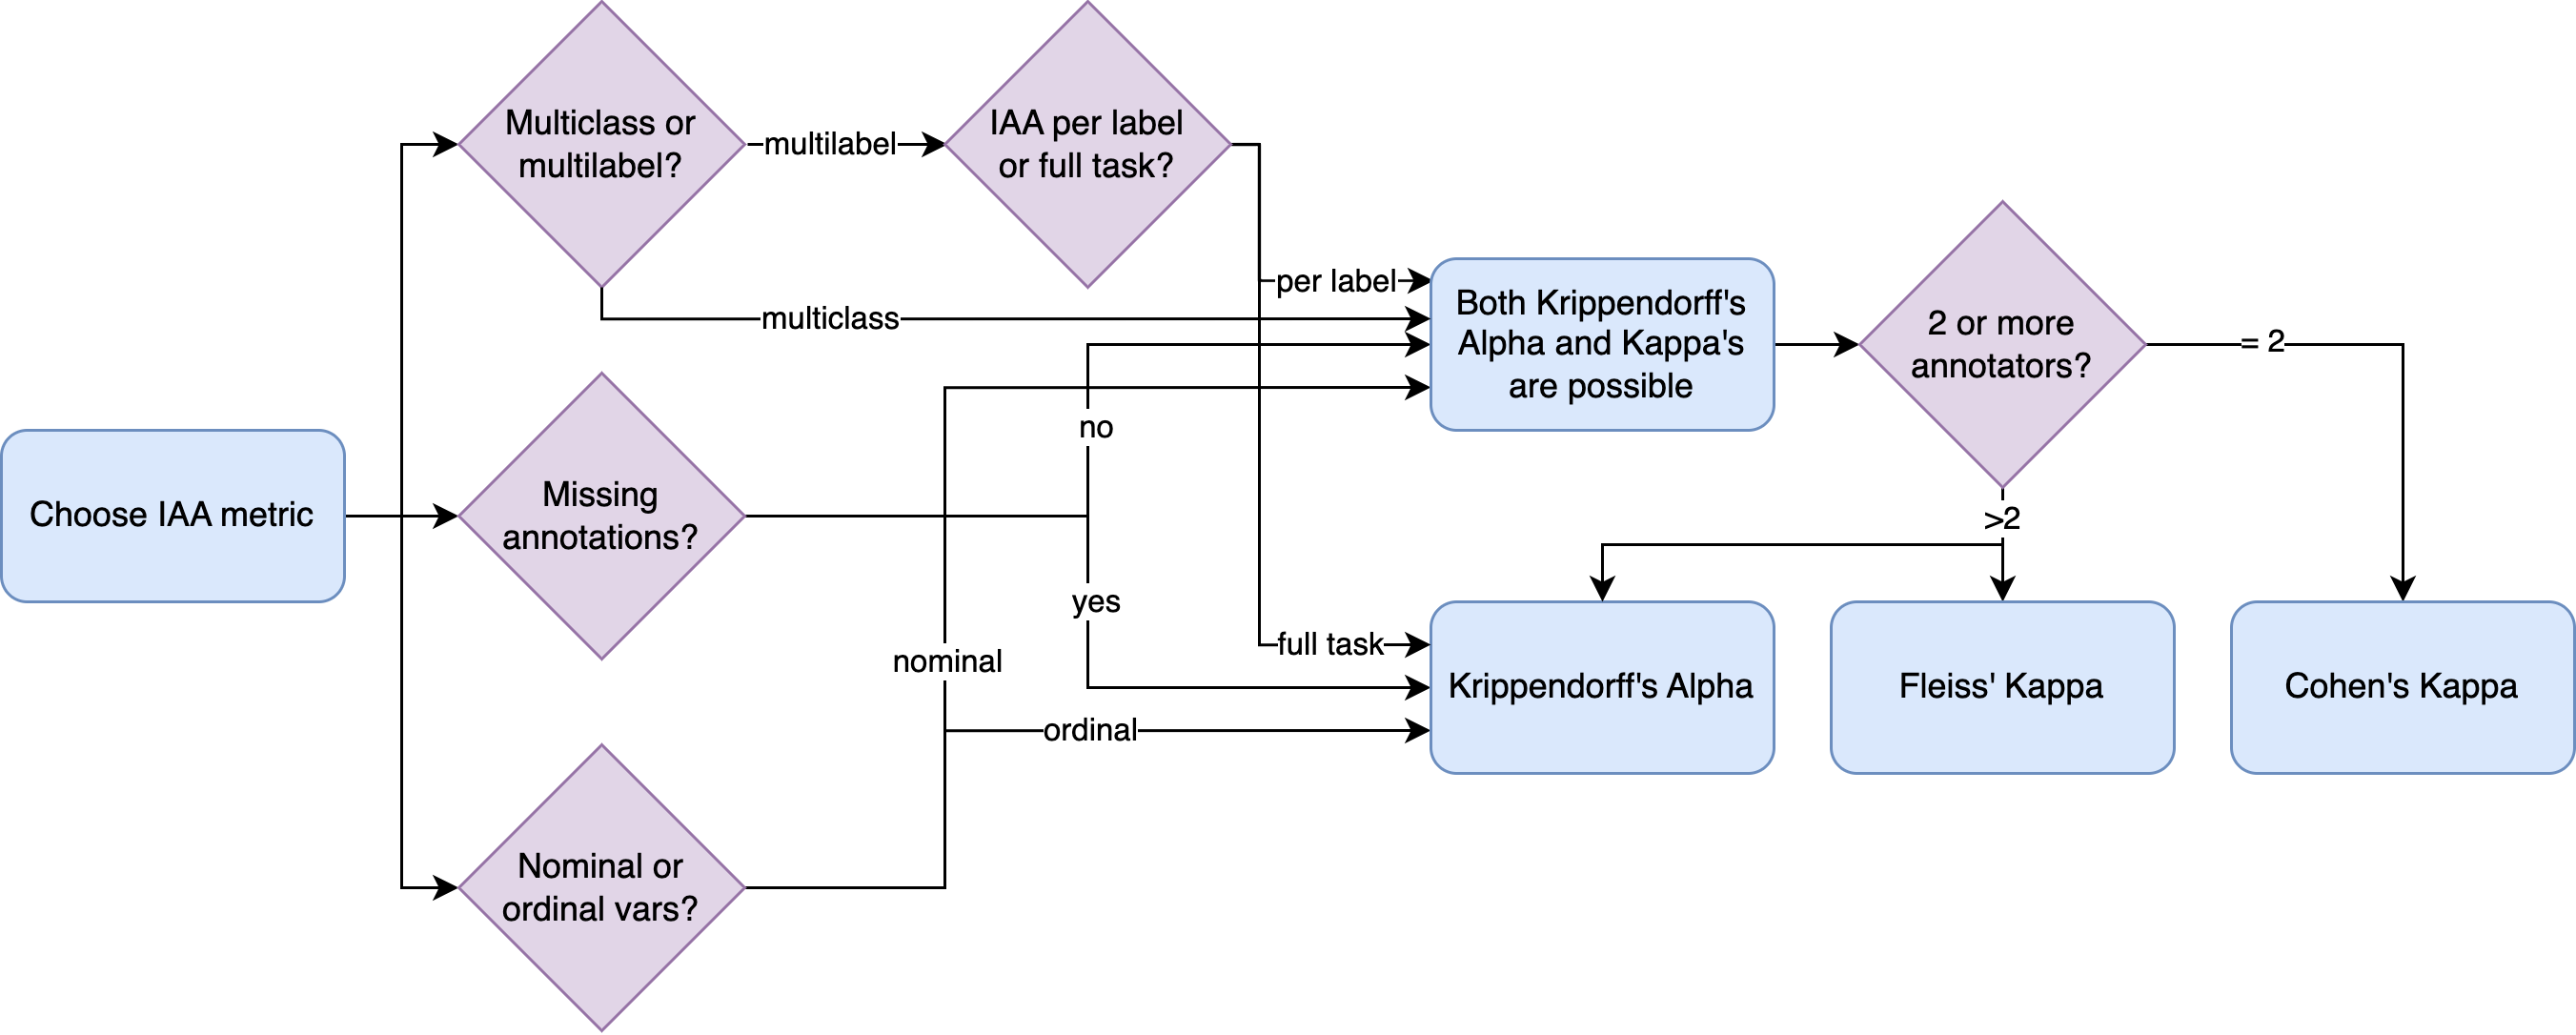

The remainder of this section discusses these three metrics in more detail.

### 4.2.1 Cohen's Kappa

#### 4.2.1.1 Key concepts

**Oberserved Agreement (P_o)**

- Proportion of items on which the annotators agree.
- Calculated as the number of items with the same category assignment by both annotators divided by the total number of items.

**Expected Agreement (P_e)**

- The proportion of agreement that would be expected by chance alone.
- Calculated based on the distribution of categories assigned by each annotator.

#### 4.2.1.2 Requirements

- The metric can only be used between two annotators.
- There can be no missing labels.
- Each annotator can only assign one label to each instance (binary or multiclass, but not multilabel). In other words, the metric assumes mutually exclusive categories.
- The metric assumes nominal distance between categories. Each category is equally different from other categories. [Note that weighted Kappa can be used in case of ordinal categories. In this notebook, we only discuss ordinal instances under Krippendorff's Alpha.] 

#### 4.2.1.3 Formula

$$ \kappa = \frac{P_o - P_e}{1 - P_e} $$

#### 4.2.1.4 Example of $P_o$ and $P_e$ calculations

|                   | Annotator 2: A | Annotator 2: B | Annotator 2: C |
|-------------------|----------------|----------------|----------------|
| Annotator 1: A   | 20             | 5              | 5              |
| Annotator 1: B   | 2              | 10             | 3              |
| Annotator 1: C   | 1              | 4              | 0              |


**Observed Agreement (Po)**:

- Calculate the sum of the diagonal (agreements): $20 + 10 + 0 = 30$
- $P_o$ = $\frac{30}{50} = 0.6$

**Expected Agreement (Pe)**:

Calculate the row and column totals for each category:
- For A: Row total = 30, Column total = 23
- For B: Row total = 15, Column total = 19
- For C: Row total = 5, Column total = 8

Calculate $P_e$ using the formula for each category and summing them up:
$P_{eA} = \left( \frac{30}{50} \right) \times \left( \frac{23}{50} \right) = 0.276$
$P_{eB} = \left( \frac{15}{50} \right) \times \left( \frac{19}{50} \right) = 0.114$
$P_{eC} = \left( \frac{5}{50} \right) \times \left( \frac{8}{50} \right) = 0.016$

$P_e = P_{eA} + P_{eB} + P_{eC} = 0.276 + 0.114 + 0.016 = 0.406$

#### 4.2.1.5 Interpretation

The value of Cohen's Kappa ranges from -1 to 1:

- κ = 1: Perfect agreement.
- κ = 0: Agreement equivalent to chance.
- κ < 0: Less agreement than expected by chance (indicating disagreement).

[Thresholds for interpreting Kappa](https://www.jstor.org/stable/2529310) are:

- κ < 0: No agreement
- 0.01–0.20: Slight agreement
- 0.21–0.40: Fair agreement
- 0.41–0.60: Moderate agreement
- 0.61–0.80: Substantial agreement
- 0.81–1.00: Almost perfect agreement

#### 4.2.1.6 Run Cohen's Kappa on your data

Note that this code will only work for two annotators. If you have more than two annotators, we advise you to use the metrics below.

In [22]:
cohen_kappa = task.kappa()
print(f"Cohen's Kappa score on your annotations: {cohen_kappa}")

### 4.2.2 Fleiss' Kappa

#### 4.2.2.1 Key concepts & requirements

*Multiple annotators*: Fleiss' Kappa is designed to assess the level of agreement among multiple annotators (more than two).

*Observed vs. Expected Agreement*: Similar to Cohen's Kappa, Fleiss' Kappa compares the observed agreement among annotators with the expected agreement under the assumption of independence.

*No missing labels*: Each instance has to be annotated by all annotators.

*Mutually exclusive categories*: Each annotator can only assign one label to each instance (binary or multiclass, but not multilabel).

*Nominal data*: The metric assumes nominal distance between categories. Each category is equally different from other categories.

#### 4.2.2.2 Formula

$$ \kappa_f = \frac{\bar{P} - \bar{P}_e}{1 - \bar{P}_e} $$

Where:
- $\bar{P}$ is the overall observed proportion of agreement across all items.
- $\bar{P}_e$ is the expected proportion of agreement under the assumption of independence.

#### 4.2.2.3 Example of Fleiss' Kappa calculations

For an example on how Fleiss' Kappa is calculated on a dataset, we refer interested readers to [this blogpost on Fleiss' Kappa](https://datatab.net/tutorial/fleiss-kappa).

#### 4.2.2.4 Interpretation

The interpretation of Fleiss' Kappa is similar to Cohen's Kappa (see Section 4.2.1.4):

- $\kappa_f$ = 1: Perfect agreement.
- $\kappa_f$ = 0: Agreement equivalent to chance.
- $\kappa_f$ < 0: Less agreement than expected by chance (indicating disagreement).

[Thresholds for interpreting Kappa](https://www.jstor.org/stable/2529310) are:

- $\kappa_f$ < 0: No agreement
- 0.01–0.20: Slight agreement
- 0.21–0.40: Fair agreement
- 0.41–0.60: Moderate agreement
- 0.61–0.80: Substantial agreement
- 0.81–1.00: Almost perfect agreement

#### 4.2.2.5 Run Fleiss' Kappa on your data

In [23]:
fleiss_kappa = task.multi_kappa()
print(f"Fleiss' Kappa score on your annotations: {fleiss_kappa}")

### 4.2.3 Krippendorff's Alpha

#### 4.2.3.1 Key concepts

*Multiple raters*: Krippendorff's Alpha is designed to handle agreement among multiple raters, making it suitable for situations where two or more individuals are involved in the classification of items.

*Different measurement scales*: Unlike Cohen's or Fleiss' Kappa, which is primarily designed for nominal categorical data, Krippendorff's Alpha can handle various types of measurement scales, including nominal, ordinal, interval, and ratio. You can customize the distance metric.

*Missing data*: Krippendorff's Alpha can accommodate missing data in the annotations, allowing for flexibility in data collection scenarios where not all items are rated by all annotators.

*Multilabeled data*: In contrast to Cohen's or Fleiss' Kappa, Krippendorff's Alpha can handle non-mutually exclusive categories (in other words, multilabel data). You can customize the distance metric to set distance metrics (e.g., Jaccard Distance).

#### 4.2.3.2 Formula

**Krippendorff's Alpha (α)** is calculated based on the observed and expected disagreement among annotators. The formula for Krippendorff's Alpha depends on the type of measurement scale:

The general formula to calculate Alpha is $\alpha = 1 - \frac{D_o}{D_e}$
- $D_o$ is the oberserved disagreement among annotators.
- $D_e$ is the expected disagreement under the assumption of independence.

#### 4.2.3.3 Example of Krippendorff's Alpha calculations

Depending on the annotation setup, different distance metrics are used. We refer interested readers to [Krippendorff's paper on "Computing Krippendorff’s Alpha-Reliability"](https://www.asc.upenn.edu/sites/default/files/2021-03/Computing%20Krippendorff%27s%20Alpha-Reliability.pdf) for more details and examples on how the metric can be calculated across different settings.

#### 4.2.3.4 Interpretation

The value of Krippendorff's Alpha ranges from 0 to 1:

- $\alpha = 1$: Perfect agreement.
- $\alpha = 0$: Agreement equivalent to chance.
- $\alpha < 0$: Less agreement than expected by chance (indicating disagreement).

Interpretation of Krippendorff's Alpha depends on the specific context of the data and the measurement scale used. Generally, higher values of Krippendorff's Alpha indicate higher levels of agreement among the annotators.

[Thresholds for interpreting Krippendorff's Alpha](https://us.sagepub.com/en-us/nam/content-analysis/book258450) are:
- 0.80-1.00: Reliable value
- 0.67-0.79: Acceptable for tentative conclusions
- 0.00-0.66: Not acceptable

#### 4.2.3.5 Run Krippendorff's Alpha on your data

Code to run a vanilla version of Krippendorff's Alpha without special distance metrics:

In [24]:
kripp_alpha = task.alpha()
print(f"Krippendorff's Alpha score on your annotations: {kripp_alpha}")

Code to customize distance metrics in Krippendorff's Alpha. \
Note that this code will not work for our data, since we're not working with ordinal scores or in a multilabel setup.

In [25]:
# multilabel setting (used when multiple labels are assigned per instance)
task = AnnotationTask(data, distance=jaccard_distance)
kripp_alpha = task.alpha()
print(f"Krippendorff's Alpha score on your annotations: {kripp_alpha}")

In [150]:
# ordinal distance metric
def absolute_diff(label1, label2):
    return norm(label1 - label2)

In [26]:
# Krippendorff's Alpha with ordinal distance
task = AnnotationTask(data, distance=absolute_diff)
kripp_alpha = task.alpha()
print(f"Krippendorff's Alpha with absolute difference: {kripp_alpha}")